# Experimenting with different chunk sizes

In [1]:
from rolling.pdf import list_pdfs, read_pdf
pdfs = list_pdfs()
len(pdfs), pdfs[:3]

(1020,
 ['./arxiv_downloads\\0808.2870v1.Measuring_Distance_and_Properties_of_the_Milky_Way_s_Central_Supermassive_Black_Hole_with_Stellar_Orbits.pdf',
  './arxiv_downloads\\0809.4677v1.Approaching_the_event_horizon__1_3mm_VLBI_of_SgrA_.pdf',
  './arxiv_downloads\\0812.0743v2.A_Novel_Clustering_Algorithm_Based_on_Quantum_Games.pdf'])

In [2]:
paper = read_pdf(pdfs[0])
len(paper.split(' '))

46652

In [3]:
from rolling.embedding import GTEEmbeddingModel
model = GTEEmbeddingModel()
model.max_size

8192

In [4]:
# see how adding a word changes the embedding
words = paper.split(' ')
sentences = []
text = ""
for word in words:
    text += word + " "
    sentences.append(text.strip())

len(sentences), sentences[:5]

(9543,
 ['arXiv:0812.0743v2',
  'arXiv:0812.0743v2 [cs.LG]',
  'arXiv:0812.0743v2 [cs.LG] 10',
  'arXiv:0812.0743v2 [cs.LG] 10 Oct',
  'arXiv:0812.0743v2 [cs.LG] 10 Oct 2009'])

In [5]:
embeddings = model.encode(sentences, batch_size=1, progressbar=True)

100%|██████████| 9543/9543 [06:37<00:00, 24.01it/s] 


In [ ]:
from rolling.embedding import get_similarity

changes = []
for txt_from in range(1, len(embeddings)):
    emb1 = embeddings[txt_from-1]
    emb2 = embeddings[txt_from]
    change = 1 - get_similarity(emb1, emb2)
    changes.append(change)

len(changes), changes[:5]

(9542,
 [np.float16(0.08936),
  np.float16(0.004395),
  np.float16(0.007324),
  np.float16(0.03418),
  np.float16(0.004883)])

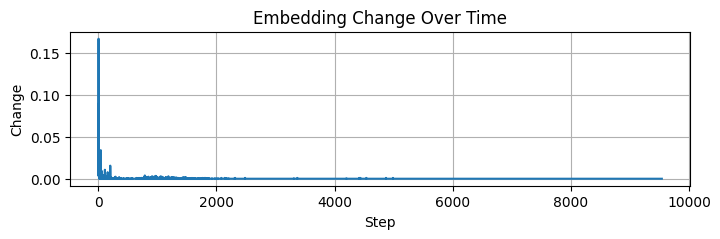

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 2))
# plt.xlim(0.6, 1.0)
plt.plot(changes)
plt.title("Embedding Change Over Time")
plt.xlabel("Step")
plt.ylabel("Change")
plt.grid(True)
plt.show()

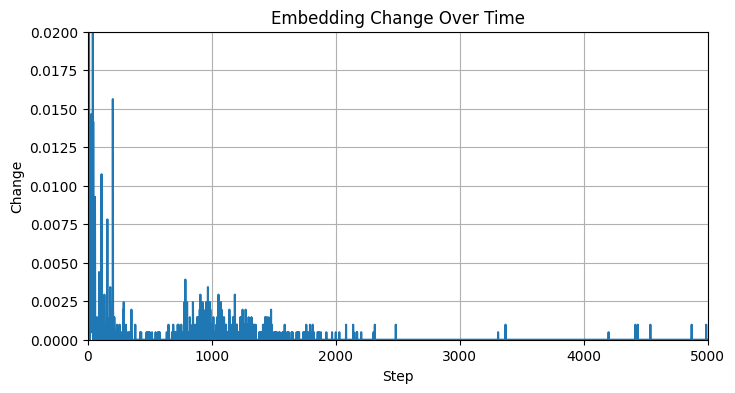

In [19]:
plt.figure(figsize=(8, 4))
plt.ylim(0, 0.02)
plt.xlim(0, 5000)
plt.plot(changes)
plt.title("Embedding Change Over Time")
plt.xlabel("Step")
plt.ylabel("Change")
plt.grid(True)
plt.show()

---

In [4]:
import os
download_dir = './arxiv_downloads'
if not os.path.exists(download_dir):
    os.mkdir(download_dir)

In [29]:
import arxiv

def download_if_new(result:arxiv.Result):
    filename = result._get_default_filename()
    filepath = os.path.join(download_dir, filename)
    if os.path.exists(filepath):
        print(f'Skipping {result.entry_id}')
        return
    
    try:
        result.download_pdf(dirpath=download_dir)
        print(f'Downloaded {result.entry_id}')
    except Exception as e:
        print(f"Error downloading {filename}: {e}")
        return None
    return filepath

In [4]:
papers_cow = (
    '2105.09782', '1811.09918', '2106.03643', '1005.1381', '2203.09606', '2101.10445', '2307.13994', '2405.15550', '2110.07103', '2407.20372'
)
papers_blackhole = (
    '1511.08596', 'astro-ph/0611950', '0808.2870', '0906.1492', '1302.5116', 'astro-ph/9809222', 'astro-ph/0003433', '0906.5351', '0809.4677', '1805.05051'
)

In [39]:
client = arxiv.Client()

for result in client.results(arxiv.Search(id_list=papers_cow)):
    download_if_new(result)
for result in client.results(arxiv.Search(id_list=papers_blackhole)):
    download_if_new(result)

Downloaded http://arxiv.org/abs/2105.09782v2
Downloaded http://arxiv.org/abs/1811.09918v1
Downloaded http://arxiv.org/abs/2106.03643v1
Downloaded http://arxiv.org/abs/1005.1381v2
Downloaded http://arxiv.org/abs/2203.09606v1
Downloaded http://arxiv.org/abs/2101.10445v1
Downloaded http://arxiv.org/abs/2307.13994v1
Downloaded http://arxiv.org/abs/2405.15550v1
Downloaded http://arxiv.org/abs/2110.07103v1
Downloaded http://arxiv.org/abs/2407.20372v1
Downloaded http://arxiv.org/abs/1511.08596v1
Downloaded http://arxiv.org/abs/astro-ph/0611950v2
Downloaded http://arxiv.org/abs/0808.2870v1
Downloaded http://arxiv.org/abs/0906.1492v2
Downloaded http://arxiv.org/abs/1302.5116v1
Downloaded http://arxiv.org/abs/astro-ph/9809222v1
Downloaded http://arxiv.org/abs/astro-ph/0003433v1
Downloaded http://arxiv.org/abs/0906.5351v1
Downloaded http://arxiv.org/abs/0809.4677v1
Downloaded http://arxiv.org/abs/1805.05051v3


In [5]:
from rolling.pdf import list_pdfs, read_pdf
pdfs = list_pdfs()

paths_cow = [
    path
    for id in papers_cow
    for path in pdfs
    if id in path
]
assert len(paths_cow) == len(papers_cow), f'{len(paths_cow)} != {len(papers_cow)}'

paths_blackhole = [
    path
    for id in papers_blackhole
    for path in pdfs
    if id.replace('/', '_') in path
]
assert len(paths_blackhole) == len(papers_blackhole), f'{len(paths_blackhole)} != {len(papers_blackhole)}'

In [6]:
papers_cow = [read_pdf(path) for path in paths_cow]
papers_blackhole = [read_pdf(path) for path in paths_blackhole]

Ignoring wrong pointing object 8 0 (offset 0)
Ignoring wrong pointing object 10 0 (offset 0)
Ignoring wrong pointing object 12 0 (offset 0)
Ignoring wrong pointing object 14 0 (offset 0)
Ignoring wrong pointing object 16 0 (offset 0)
Ignoring wrong pointing object 18 0 (offset 0)
Ignoring wrong pointing object 20 0 (offset 0)
Ignoring wrong pointing object 29 0 (offset 0)
Ignoring wrong pointing object 31 0 (offset 0)
Ignoring wrong pointing object 33 0 (offset 0)
Ignoring wrong pointing object 43 0 (offset 0)
Ignoring wrong pointing object 71 0 (offset 0)
Ignoring wrong pointing object 81 0 (offset 0)
Ignoring wrong pointing object 95 0 (offset 0)


---
# Visualize how different sized chunk embeddings start to lose meaning

In [7]:
import numpy as np
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from rolling.pdf import chunk_text

embeddings_cow = np.array([
    np.mean(model.encode(chunk_text(paper, size=1024)), axis=0)
    for paper in papers_cow
])
embeddings_blackhole = np.array([
    np.mean(model.encode(chunk_text(paper, size=1024)), axis=0)
    for paper in papers_blackhole
])
embeddings_cow.shape

(10, 768)

In [8]:
all_embeddings = np.vstack([embeddings_cow, embeddings_blackhole])
reducer = PCA(n_components=2)
embedding_2d = reducer.fit_transform(all_embeddings)

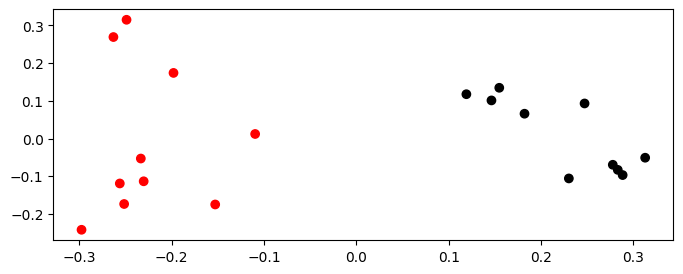

In [9]:
colors = ['red'] * 10 + ['black'] * 10  # cow is red
plt.figure(figsize=(8,3))
plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=colors)
plt.show()

In [13]:
import os
plot_export_dir = 'plot_exports'
os.makedirs(plot_export_dir, exist_ok=True)

Plotting chunk size 8192: 119 vs. 144


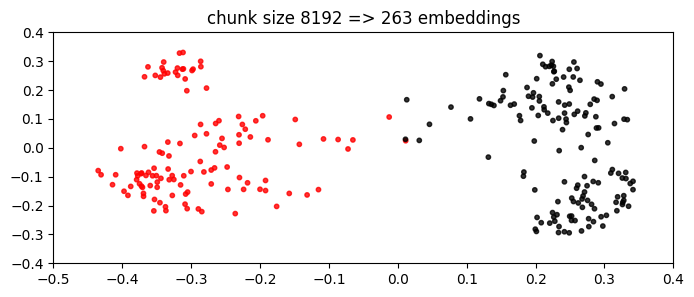

In [10]:

def chunk_and_plot(chunk_size:int, alpha, size, save_path=None, figsize=(8,4)):
    batch_size = min(32768 // chunk_size + 1, 1024)
    embeddings_cow = np.vstack([
        model.encode(chunk_text(paper, size=chunk_size), batch_size=batch_size)
        for paper in papers_cow
    ])
    embeddings_blackhole = np.vstack([
        model.encode(chunk_text(paper, size=chunk_size), batch_size=batch_size)
        for paper in papers_blackhole
    ])
    all_embeddings = np.vstack([embeddings_cow, embeddings_blackhole])

    reducer = PCA(n_components=2, random_state=42)
    embedding_2d = reducer.fit_transform(all_embeddings)
    
    print(f'Plotting chunk size {chunk_size}: {len(embeddings_cow)} vs. {len(embeddings_blackhole)}')

    colors = ['red'] * len(embeddings_cow) + ['black'] * len(embeddings_blackhole)  # cow is red

    def _prep_plot():
        plt.figure(figsize=figsize)
        plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=colors, alpha=alpha, s=size)
        plt.title(f'chunk size {chunk_size} => {len(all_embeddings)} embeddings')
        plt.xlim(-0.5, 0.4)
        plt.ylim(-0.4, 0.4)


    if save_path:
        # Hack: save multiple variants in different orientations because PCA might swap it
        # no easy way to guarantee it stays the same? have to hand select...

        _prep_plot()
        plt.savefig(save_path.replace('.png', '-v1.png'), dpi=300, bbox_inches='tight')
        plt.close()
        
        embedding_2d[:, 0] *= -1
        _prep_plot()
        plt.savefig(save_path.replace('.png', '-v2.png'), dpi=300, bbox_inches='tight')
        plt.close()
        
        embedding_2d[:, 1] *= -1
        _prep_plot()
        plt.savefig(save_path.replace('.png', '-v3.png'), dpi=300, bbox_inches='tight')
        plt.close()
        
        embedding_2d[:, 0] *= -1
        _prep_plot()
        plt.savefig(save_path.replace('.png', '-v4.png'), dpi=300, bbox_inches='tight')
        plt.close()
    else:
        _prep_plot()
        plt.show()
    

chunk_and_plot(8192, alpha=0.8, size=10, figsize=(8, 3))
# chunk_and_plot(4096, alpha=0.3, size=2, save_path=os.path.join(plot_export_dir, f'{1:03}.png'))
# chunk_and_plot(2048, alpha=0.3, size=2)
# chunk_and_plot(64 , alpha=0.08, size=1.3)
# chunk_and_plot(32, alpha=0.02,  size=1.0)
# chunk_and_plot(4 , alpha=0.005, size=1.5)

[8191 8050 7912 7776 7642 7510 7381 7254 7129 7006 6886 6767 6651 6536
 6424 6313 6204 6097 5992 5889 5788 5688 5590 5494 5400 5307 5215 5125
 5037 4950 4865 4781 4699 4618 4539 4461 4384 4308 4234 4161 4090 4019
 3950 3882 3815 3749 3685 3621 3559 3498 3438 3378 3320 3263 3207 3152
 3097 3044 2992 2940 2890 2840 2791 2743 2696 2649 2604 2559 2515 2471
 2429 2387 2346 2306 2266 2227 2188 2151 2114 2077 2042 2006 1972 1938
 1905 1872 1840 1808 1777 1746 1716 1687 1657 1629 1601 1573 1546 1520
 1493 1468 1442 1418 1393 1369 1346 1322 1300 1277 1255 1234 1212 1192
 1171 1151 1131 1112 1092 1074 1055 1037 1019 1002  984  967  951  934
  918  902  887  872  857  842  827  813  799  785  772  758  745  733
  720  708  695  683  672  660  649  637  626  616  605  595  584  574
  564  555  545  536  527  517  509  500  491  483  474  466  458  450
  443  435  427  420  413  406  399  392  385  378  372  365  359  353
  347  341  335  329  324  318  313  307  302  297  292  287  282  277
  272 

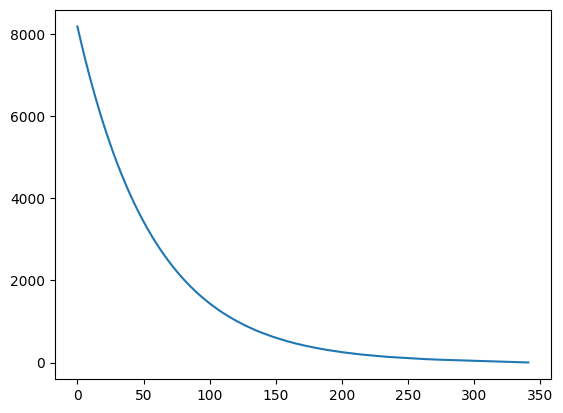

In [11]:
chunk_sizes = np.logspace(np.log10(8192), np.log10(2), 480, dtype=np.int32)
chunk_sizes = np.sort(np.unique(chunk_sizes))[::-1]
print(chunk_sizes)
plt.plot(chunk_sizes)

In [ ]:
N = len(chunk_sizes)
for i, c, a, s in zip(
    range(N,),
    chunk_sizes,
    np.logspace(np.log10(1), np.log10(0.008), N),
    np.logspace(np.log10(10), np.log10(1.5), N),
):
    path = os.path.join(plot_export_dir, f'{c:04d}.png')
    chunk_and_plot(chunk_size=c, alpha=a, size=s, figsize=(8, 3), save_path=path)

Plotting chunk size 272: 3484 vs. 4242
Plotting chunk size 267: 3567 vs. 4336
Plotting chunk size 263: 3624 vs. 4401
Plotting chunk size 258: 3676 vs. 4473
Plotting chunk size 254: 3739 vs. 4542
Plotting chunk size 249: 3826 vs. 4651
Plotting chunk size 245: 3900 vs. 4733
Plotting chunk size 241: 3957 vs. 4813
Plotting chunk size 237: 4033 vs. 4893
Plotting chunk size 233: 4106 vs. 4978
Plotting chunk size 229: 4175 vs. 5065
Plotting chunk size 225: 4249 vs. 5159
Plotting chunk size 221: 4333 vs. 5252
Plotting chunk size 217: 4412 vs. 5350
Plotting chunk size 213: 4495 vs. 5456
Plotting chunk size 209: 4583 vs. 5559
Plotting chunk size 206: 4625 vs. 5612
Plotting chunk size 202: 4726 vs. 5726
Plotting chunk size 199: 4822 vs. 5841
Plotting chunk size 195: 4921 vs. 5966
Plotting chunk size 192: 4981 vs. 6025
Plotting chunk size 189: 5087 vs. 6155
Plotting chunk size 185: 5197 vs. 6291
Plotting chunk size 182: 5256 vs. 6361
Plotting chunk size 179: 5377 vs. 6507
Plotting chunk size 176: 

In [ ]:
# output_files = os.listdir(plot_export_dir)
# output_files = sorted(output_files, reverse=True)

# for i, file in enumerate(output_files):
#     new_name = f'frame_{i:04d}.png'
#     os.rename(os.path.join(plot_export_dir, file), os.path.join(plot_export_dir, new_name))

---

Plotting chunk size 8192


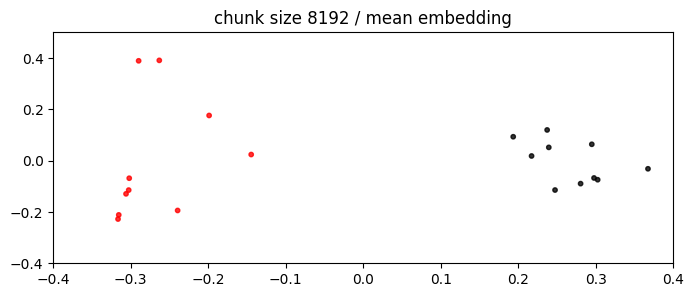

In [41]:
import numpy as np
def chunk_and_plot_mean(chunk_size:int, alpha, size, save_path=None, figsize=(8,4)):
    batch_size = min(32768 // chunk_size + 1, 1024)
    embeddings_cow = np.vstack([
        np.mean(model.encode(chunk_text(paper, size=chunk_size, hard_cut=True), batch_size=batch_size), axis=0)
        for paper in papers_cow
    ])
    embeddings_blackhole = np.vstack([
        np.mean(model.encode(chunk_text(paper, size=chunk_size, hard_cut=True), batch_size=batch_size), axis=0)
        for paper in papers_blackhole
    ])
    all_embeddings = np.vstack([embeddings_cow, embeddings_blackhole])

    reducer = PCA(n_components=2, random_state=42)
    embedding_2d = reducer.fit_transform(all_embeddings)
    
    print(f'Plotting chunk size {chunk_size}')

    colors = ['red'] * len(embeddings_cow) + ['black'] * len(embeddings_blackhole)  # cow is red

    def _prep_plot():
        plt.figure(figsize=figsize)
        plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=colors, alpha=alpha, s=size)
        plt.title(f'chunk size {chunk_size} / mean embedding')
        plt.xlim(-0.4, 0.4)
        plt.ylim(-0.4, 0.5)


    if save_path:
        # Hack: save multiple variants in different orientations because PCA might swap it
        # no easy way to guarantee it stays the same? have to hand select...

        _prep_plot()
        plt.savefig(save_path.replace('.png', '-v1.png'), dpi=300, bbox_inches='tight')
        plt.close()
        
        embedding_2d[:, 0] *= -1
        _prep_plot()
        plt.savefig(save_path.replace('.png', '-v2.png'), dpi=300, bbox_inches='tight')
        plt.close()
        
        embedding_2d[:, 1] *= -1
        _prep_plot()
        plt.savefig(save_path.replace('.png', '-v3.png'), dpi=300, bbox_inches='tight')
        plt.close()
        
        embedding_2d[:, 0] *= -1
        _prep_plot()
        plt.savefig(save_path.replace('.png', '-v4.png'), dpi=300, bbox_inches='tight')
        plt.close()
    else:
        _prep_plot()
        plt.show()
    

chunk_and_plot_mean(8192, alpha=0.8, size=10, figsize=(8, 3))

In [43]:
chunk_sizes = np.logspace(np.log10(8192), np.log10(1), 64, dtype=np.int32)
chunk_sizes = np.sort(np.unique(chunk_sizes))[::-1]
print(chunk_sizes)

[8191 7100 6153 5333 4622 4006 3472 3010 2608 2261 1959 1698 1472 1276
 1105  958  830  720  624  540  468  406  352  305  264  229  198  172
  149  129  112   97   84   73   63   54   47   41   35   30   26   23
   20   17   15   13   11    9    8    7    6    5    4    3    2    1]


In [44]:
N = len(chunk_sizes)
for i, c in zip(
    range(N,),
    chunk_sizes,
):
    path = os.path.join(plot_export_dir, f'{c:04d}.png')
    # chunk_and_plot_mean(chunk_size=c, alpha=0.8, size=10, figsize=(4,2))
    chunk_and_plot_mean(chunk_size=c, alpha=0.8, size=10, figsize=(8, 3), save_path=path)

Plotting chunk size 8191
Plotting chunk size 7100
Plotting chunk size 6153
Plotting chunk size 5333
Plotting chunk size 4622
Plotting chunk size 4006
Plotting chunk size 3472
Plotting chunk size 3010
Plotting chunk size 2608
Plotting chunk size 2261
Plotting chunk size 1959
Plotting chunk size 1698
Plotting chunk size 1472
Plotting chunk size 1276
Plotting chunk size 1105
Plotting chunk size 958
Plotting chunk size 830
Plotting chunk size 720
Plotting chunk size 624
Plotting chunk size 540
Plotting chunk size 468
Plotting chunk size 406
Plotting chunk size 352
Plotting chunk size 305
Plotting chunk size 264
Plotting chunk size 229
Plotting chunk size 198
Plotting chunk size 172
Plotting chunk size 149
Plotting chunk size 129
Plotting chunk size 112
Plotting chunk size 97
Plotting chunk size 84
Plotting chunk size 73
Plotting chunk size 63
Plotting chunk size 54
Plotting chunk size 47
Plotting chunk size 41
Plotting chunk size 35
Plotting chunk size 30
Plotting chunk size 26
Plotting ch

---

In [62]:
chunk_size = 1
batch_size = min(32768 // chunk_size + 1, 1024)
embeddings_cow = np.vstack([
    np.mean(model.encode(chunk_text(paper, size=chunk_size, hard_cut=True), batch_size=batch_size), axis=0)
    for paper in papers_cow
])
embeddings_blackhole = np.vstack([
    np.mean(model.encode(chunk_text(paper, size=chunk_size, hard_cut=True), batch_size=batch_size), axis=0)
    for paper in papers_blackhole
])
all_embeddings = np.vstack([embeddings_cow, embeddings_blackhole])
reducer = PCA(n_components=2, random_state=42)
embedding_2d = reducer.fit_transform(all_embeddings)

(array([ 1,  3,  4,  5,  6,  7,  8,  9, 10, 13, 14, 17, 19]),)
(array([11, 12, 15, 16, 18]),)
(array([0, 2]),)


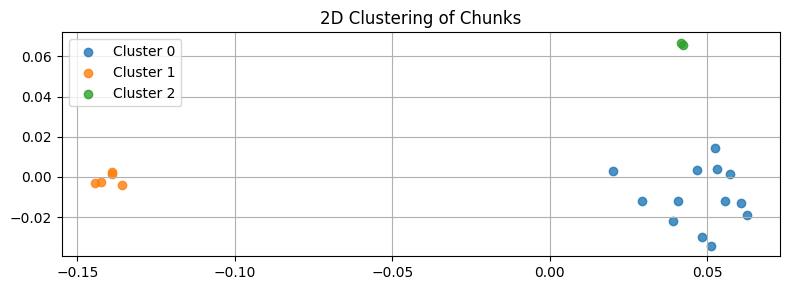

In [131]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

# Cluster
N = 3
kmeans = KMeans(n_clusters=N, random_state=42)
labels = kmeans.fit_predict(embedding_2d)

plt.figure(figsize=(8,3))
for cluster_id in range(N):
    indices = np.where(labels == cluster_id)
    print(indices)
    plt.scatter(embedding_2d[indices, 0], embedding_2d[indices, 1], label=f'Cluster {cluster_id}', alpha=0.8)

plt.title("2D Clustering of Chunks")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [107]:
papers = papers_cow + papers_blackhole
for cluster_id in range(N):
    idx = np.where(labels == cluster_id)[0]
    print(f'Cluster {cluster_id}')
    for pi, paper in enumerate(papers):
        if pi in idx:
            print(f' - {len(paper)}')

Cluster 0
 - 25470
 - 64504
 - 33078
 - 42970
 - 38601
 - 75441
 - 22887
 - 66958
 - 20897
 - 64137
 - 68435
 - 22695
 - 91420
Cluster 1
 - 21382
 - 130103
 - 24530
 - 106261
 - 21652
Cluster 2
 - 32916
 - 61162


In [108]:
from collections import Counter

wordcounts = [
    [
        Counter(text)
        for pi, text in enumerate(papers)
        if pi in np.where(labels == i)[0]
    ]
    for i in range(N)
]

for wclist in wordcounts:
    for wc in wclist:
        print(wc.most_common()[:5])
    print("---")

wordcounts_flat = []
for list in wordcounts:
    wordcounts_flat.extend(list)

[(' ', 4068), ('e', 2331), ('t', 1797), ('a', 1666), ('i', 1527)]
[(' ', 12100), ('e', 4952), ('t', 3817), ('i', 3662), ('n', 3282)]
[(' ', 5175), ('e', 2670), ('i', 1921), ('a', 1786), ('t', 1686)]
[(' ', 6737), ('e', 3692), ('n', 2559), ('a', 2540), ('t', 2470)]
[(' ', 5811), ('e', 3336), ('a', 2604), ('t', 2447), ('i', 2281)]
[(' ', 12005), ('e', 6775), ('a', 4977), ('t', 4493), ('i', 4463)]
[(' ', 3571), ('e', 1826), ('o', 1512), ('a', 1479), ('t', 1376)]
[(' ', 9676), ('e', 6219), ('i', 4408), ('a', 4219), ('t', 4168)]
[(' ', 3539), ('e', 1667), ('t', 1227), ('a', 1163), ('o', 1121)]
[(' ', 11108), ('e', 6025), ('t', 4364), ('a', 4113), ('i', 3306)]
[(' ', 11912), ('e', 6144), ('t', 4521), ('a', 3821), ('i', 3548)]
[(' ', 4048), ('e', 1769), ('t', 1331), ('a', 1324), ('i', 1155)]
[(' ', 15484), ('e', 8266), ('t', 5663), ('a', 4852), ('i', 4563)]
---
[(' ', 7509), ('e', 1387), ('t', 1076), ('a', 973), ('s', 827)]
[(' ', 46651), ('e', 9073), ('t', 6465), ('a', 5688), ('i', 5101)]
[(

Cluster 0
Cluster 1
Cluster 2


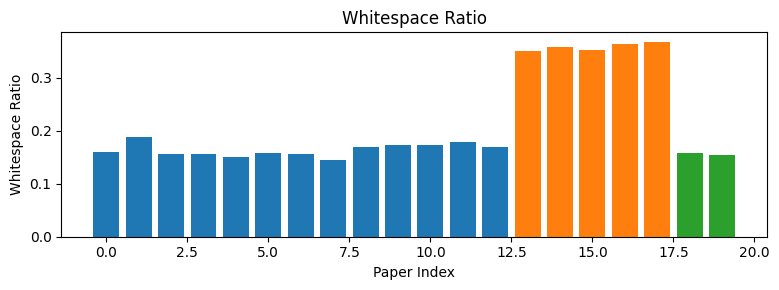

In [132]:
papers = papers_cow + papers_blackhole

import matplotlib
import matplotlib.pyplot as plt
colormap = matplotlib.colormaps['tab10']

colors = []
values = []

for cluster_id in range(N):
    idx = np.where(labels == cluster_id)[0]
    print(f'Cluster {cluster_id}')
    for pi, paper in enumerate(papers):
        if pi in idx:
            wc = Counter(paper)
            cc = len(paper)
            whitespace = wc.most_common()[0][1]
            whitespace_ratio = whitespace/cc
            colors.append(colormap(cluster_id))
            values.append(whitespace_ratio)


plt.figure(figsize=(8, 3))
plt.bar(range(len(values)), values, color=colors)
plt.xlabel('Paper Index')
plt.ylabel('Whitespace Ratio')
plt.title('Whitespace Ratio')
plt.tight_layout()
plt.show()

In [134]:
papers[1]

'Abstract Identifying dairy cows with infections such as mastitis or cows on medications is an extremely important task and legally required by the FDA’s Pasteurized Milk Ordinance. The milk produced by these dairy cows cannot be allowed to mix with the milk from healthy cows or it risks contaminating the entire bulk tank or milk truck . Ear tags, ankle bands, RFID tags and even iris patterns are some of the identification methods currently used in the dairy farms. In this work we propose the use of NIR images of cow’s mammary gland s as a novel biometric identification modality. Two datasets, containing 302 samples from 151 cows has been collected and various machine learning techniques applied to demonstrate the viability of the proposed biometric modality. The results suggest promising identification accuracy for samples collected over consecutive days. 1. Introduction Sales of milk produced from dairy cows is a multi- billion-dollar industry [1]. It is crucial to ensure the quality

In [136]:
papers[11]

'arXiv:astro-ph/0611950v2 12 Apr 2007 PA SJ: Publ .A s t r on.Soc.Japan ,1{??, c 2024.A s t r onom i calSoci et y ofJapan. T he C ore R adi us ofa St ar C l us t er C ont ai ni ng a M as s i ve B l ack Hol e D ougl asC. H eggi e SchoolofM at hem at i cs and M axwel lI ns t i t ut e f or M at hem at i calSci enc es ,U ni ver s i t y ofEdi nbur gh, K i ng’ s Bui l di ngs ,Edi nbur gh EH 9 3JZ,U K d. c. he ggi e@ e d. ac. uk Pi e t H ut I ns t i t ut e f or Advanc e d St udy,Pr i nc et on,N J 08540,U SA pi et @ i as . e du Shi nM i neshi ge Yukawa I ns t i t ut e f or The or et i c alPhys i cs ,K yot o U ni ver s i ty,Sakyo- ku,K yot o 606- 8502,Japan m i nes i ge@ yukawa. kyot o- u. ac. j p Jun M aki no Cent er f or Com put at i onalA s t r ophys i cs ,N at i onalA s t r onomi c alO bs er vat or y ofJapan, 2- 21- 1 O hs awa,M i t aka,Tokyo 181- 8588,Japan m aki no@ t h. nao. ac. j p and H ol ge r B aum gardt Ar gel ander I ns t i t ut e f or A s t r onom y ( A I f A ) ,Aufdem H □ ugel71,

^ weird spacing?

In [139]:
from pypdf import PdfReader
reader = PdfReader('./arxiv_downloads/astro-ph_0611950v2.The_core_radius_of_a_star_cluster_containing_a_massive_black_hole.pdf')
text = ""
for page in reader.pages:
    text += page.extract_text()
text

'arXiv:astro-ph/0611950v2  12 Apr 2007\nPA SJ: Publ .A s t r on.Soc.Japan ,1{??, \nc\r 2024.A s t r onom i calSoci et y ofJapan. \nT he C ore R adi us ofa St ar C l us t er C ont ai ni ng a M as s i ve B l ack Hol e\nD ougl asC. H eggi e\nSchoolofM at hem at i cs and M axwel lI ns t i t ut e f or M at hem at i calSci enc es ,U ni ver s i t y ofEdi nbur gh, \nK i ng’ s Bui l di ngs ,Edi nbur gh EH 9 3JZ,U K \nd. c. he ggi e@ e d. ac. uk\nPi e t H ut\nI ns t i t ut e f or Advanc e d St udy,Pr i nc et on,N J 08540,U SA \npi et @ i as . e du\nShi nM i neshi ge\nYukawa I ns t i t ut e f or The or et i c alPhys i cs ,K yot o U ni ver s i ty,Sakyo- ku,K yot o 606- 8502,Japan\nm i nes i ge@ yukawa. kyot o- u. ac. j p\nJun M aki no\nCent er f or Com put at i onalA s t r ophys i cs ,N at i onalA s t r onomi c alO bs er vat or y ofJapan, \n2- 21- 1 O hs awa,M i t aka,Tokyo 181- 8588,Japan\nm aki no@ t h. nao. ac. j p\nand\nH ol ge r B aum gardt\nAr gel ander I ns t i t ut e f or A s t r onom y ( 